# Flowers Classification

The task in this machine learning problem is to predict the correct flower category from an image. The flowers are commonly occuring flowers in United Kingdom such as water lily and petunia. 

This notebook is based in part on the work of the github repository https://github.com/osemars/102-Flower-Classification-by-Transfer-Learning

For information about the dataset used, see 
https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

## Settings

In [30]:
# Path to training and test data
DATA_PATH = '../data'

# Number of training epochs
NUM_EPOCHS = 1

# Define the batch size
BATCH_SIZE = 32

## Setup

See the README.md file for system requirements and installation instructions.

### Imports

In [33]:
import numpy as np
import pandas as pd 
import cv2
import os
import tqdm
import glob
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms


### Observe available device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Download and prepare the dataset

Download the dataset or use from previously downloaded cache. Also define transformations to apply to the data.

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
train_data_transforms = transforms.Compose ([transforms.RandomRotation (30),
                                             transforms.RandomResizedCrop (224),
                                             transforms.RandomHorizontalFlip (),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
valid_data_transforms = transforms.Compose ([transforms.Resize (256),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
test_data_transforms = transforms.Compose ([transforms.Resize (256),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

In [7]:
# Download and extract the Flowers dataset
# Downloads a .tgz file (345MB). Takes about 4 minutes on a typical connection.
trainset = torchvision.datasets.Flowers102(root=DATA_PATH, split="train",
                                      download=True, transform=train_data_transforms)

valset = torchvision.datasets.Flowers102(root=DATA_PATH, split="val",
                                      download=True, transform=valid_data_transforms)

testset = torchvision.datasets.Flowers102(root=DATA_PATH, split="test",
                                      download=True, transform=test_data_transforms)


100%|██████████| 344862509/344862509 [04:07<00:00, 1393557.12it/s]


Extracting ../data/flowers-102/102flowers.tgz to ../data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 937045.22it/s]


100%|██████████| 14989/14989 [00:00<00:00, 54150234.85it/s]


In [34]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valset, batch_size = 64, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [11]:
# Retrive json file with flower categories to classes
import json

with open( os.path.join(DATA_PATH,'flowers-102/cat-to-name.json'), 'r') as f:
    cat_to_name = json.load(f)
class_num = len(cat_to_name)

## About the dataset

/tmp/ipykernel_1039784/3064464271.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid ra

Total number of images: 8189
Nr of images in the training set: 1020
Nr of images in the validation set: 1020
Nr of images in the test set: 6149
Each sample is of type: <class 'tuple'>
Each image is of type: <class 'torch.Tensor'> and has dimensions torch.Size([3, 224, 224])


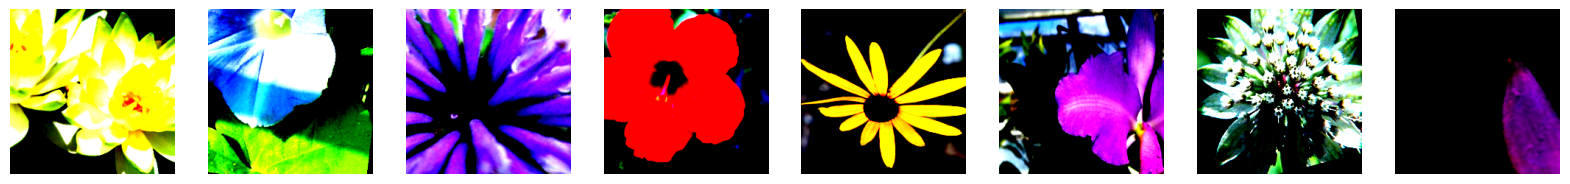

In [43]:
# Investigate the data
import random as rand

print(f"Total number of images: {len(trainset)+len(valset)+len(testset)}")
print(f"Nr of images in the training set: {len(trainset)}")
print(f"Nr of images in the validation set: {len(valset)}")
print(f"Nr of images in the test set: {len(testset)}")

# Display some random images from the training set
n_images = 8
img_indexes = rand.sample(range(0,len(trainset)), n_images)

# TODO: supress Matplotlib warnings
fig, ax = plt.subplots(1,n_images, figsize=(20, 20))
fig.show()
for i, idx in enumerate(img_indexes):
    sample = trainset[idx]
    img = sample[0]
    ax[i].imshow(img.permute(1,2,0))
    ax[i].axis('off')
fig.canvas.draw()

print(f"Each sample is of type: {type(sample)}")
img = sample[0]
print(f"Each image is of type: {type(img)} and has dimensions {img.shape}")

## Solution

### ML approach

- We split training set ??? for training and validation.
- We use a ??? model to train on the training set and evaluate on the evaluations set.
- We will use the VGG16 architecture, a CNN model with 16 layers
- The default input image size is 224x224 pixels

In [47]:
# TODO: Build and train your network
model = models.vgg16(pretrained=False)
model

/home/johal794/code/using-hpc/berzelius-intro/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/johal794/code/using-hpc/berzelius-intro/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Define the training algorithm

In [48]:
cost_train = []
accuracy_val = []
accuracy_train = []

def train(num_epochs = 1, learning_rate = 0.0001):

    # define loss and optimizer
    optimizer = optim.Adam(model.parameters(),lr = learning_rate)
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(tqdm.tqdm(train_dataloader)):
            
            data = data.to(device)
            targets = targets.to(device)
            
            # forward
            scores = model(data)
            J = loss(scores, targets)
            
            # backward
            optimizer.zero_grad()
            J.backward()
            
            # optimizer step
            optimizer.step()
            
            cost_train.append(J.item())
            
            
        acc_val = check_accuracy(valid_dataloader, model)
        accuracy_val.append(acc_val)
        
        acc_train = check_accuracy(train_dataloader, model)
        accuracy_train.append(acc_train)
        
        print(f'Epoch {epoch+1} validation accuracy {float(acc_val)*100:.2f}%')



def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, pred = scores.max(1)
            
            num_correct += ((pred == y).sum()).item()
            num_samples += pred.size(0)
            
        model.train()
        accuracy = num_correct/num_samples
    return accuracy

### Train the model

In [49]:
import datetime as dt

# Set hyperparameters
learning_rate = 0.0001
momentum = 0.9

cost_train = []
accuracy_val = []
accuracy_train = []

start = dt.datetime.now()

train(NUM_EPOCHS, learning_rate)

print(f"Training duration ", str(dt.datetime.now() - start))

100%|██████████| 16/16 [03:44<00:00, 14.01s/it]


Epoch 1 validation accuracy 0.98%
Training duration  0:06:14.531350


### View the results

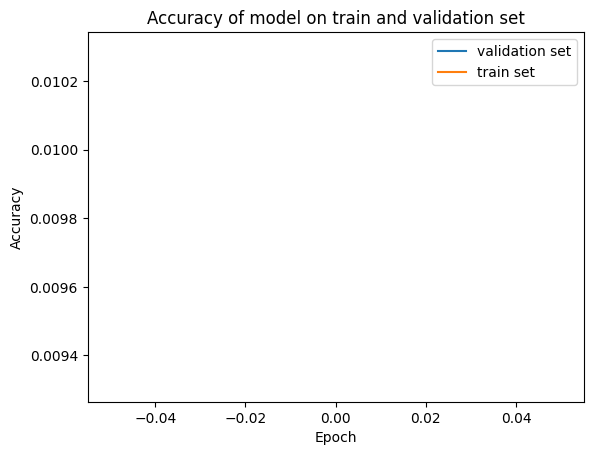

In [50]:
plt.plot(accuracy_val, label='validation set')
plt.plot(accuracy_train, label='train set')
plt.title('Accuracy of model on train and validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ploz')
plt.show()

In [51]:
# Save the entire PyTorch model to a file
name = "model"
model_path = f"models/trained_model_{name}.pth"
torch.save(model, model_path)

In [52]:
# Verify loading the saved trained model
trained_model = torch.load(model_path)
print(trained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1